# Implémentez un modèle de scoring

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
##https://www.kaggle.com/slavikonnikov/lightgbm-gpu-baseline-model-for-google-colab

## After running
! git clone --recursive https://github.com/Microsoft/LightGBM

##You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    


Cloning into 'LightGBM'...
remote: Enumerating objects: 25737, done.
remote: Total 25737 (delta 0), reused 0 (delta 0), pack-reused 25737
Receiving objects: 100% (25737/25737), 18.69 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (19017/19017), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compressing objects: 100% (5/5), done.        
remote: Total 21733 (delta 1), reused 2 (delta 0), pack-reus

In [3]:
!pip uninstall xgboost
!pip install /content/drive/MyDrive/Data_Scientist/DATA/xgboost-1.5.2-py3-none-manylinux2014_x86_64.whl

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Processing ./drive/MyDrive/Data_Scientist/DATA/xgboost-1.5.2-py3-none-manylinux2014_x86_64.whl


In [4]:
!pip install catboost 

     |████████████████████████████████| 76.6 MB 1.5 MB/s 


In [5]:
#!cat /proc/cpuinfo

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [7]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:         5392760 kB
MemAvailable:   11903480 kB
Buffers:          133488 kB
Cached:          6333620 kB
SwapCached:            0 kB
Active:          1672596 kB
Inactive:        5795548 kB
Active(anon):     832780 kB
Inactive(anon):     2516 kB
Active(file):     839816 kB
Inactive(file):  5793032 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             44108 kB
Writeback:             0 kB
AnonPages:       1000952 kB
Mapped:           699600 kB
Shmem:              3236 kB
KReclaimable:     203820 kB
Slab:             259568 kB
SReclaimable:     203820 kB
SUnreclaim:        55748 kB
KernelStack:        6192 kB
PageTables:        11524 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    4309592 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       47888 kB
VmallocChunk:          0 kB
Percpu:          

In [8]:
pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


## Résumé du projet


## Chargement des bibliothèques nécessaires

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy,  os, time,  shutil, re, glob,  os.path
import seaborn as sns
from zipfile import ZipFile
from os import listdir, path
from pathlib import Path
import time, pickle
import joblib
import shap

from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold,train_test_split, GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Constants

In [10]:
nsplits=5
seed=42

## Données

In [11]:
dir_data = Path('/content/drive/MyDrive/Data_Scientist/DATA/P7_inter') 
dir_fig  = Path('/content/drive/MyDrive/Data_Scientist/FIGURE/P7') 

filetrain=str(dir_data) + '/data_merged_train2use.csv'

file1=str(dir_data) + '/best_params_unbalanced.csv'
file2=str(dir_data) + '/cost_metier_unbalanced.csv'

file1_over=str(dir_data) + '/best_params_over.csv'
file2_over=str(dir_data) + '/cost_metier_over.csv'

file1_under=str(dir_data) + '/best_params_under.csv'
file2_under=str(dir_data) + '/cost_metier_under.csv'

file3=str(dir_data) + '/df_pred.csv'
file4=str(dir_data) + '/df_eval.csv'
file5=str(dir_data) + '/df_Cmatrix.csv'

file3_over=str(dir_data) + '/df_pred_over.csv'
file4_over=str(dir_data) + '/df_eval_over.csv'
file5_over=str(dir_data) + '/df_Cmatrix_over.csv'

file3_under=str(dir_data) + '/df_pred_under.csv'
file4_under=str(dir_data) + '/df_eval_under.csv'
file5_under=str(dir_data) + '/df_Cmatrix_under.csv'

In [12]:
data =pd.read_csv(filetrain)

### Pré-traitement des données

In [13]:
X=data.drop('TARGET',axis=1)
X=X.drop(['Unnamed: 0'],axis=1)
Y=data['TARGET']
X['SK_ID_CURR'].isnull().values.any()

False

In [14]:
perso_list=['SK_ID_CURR','CODE_GENDER','NAME_FAMILY_STATUS','OCCUPATION_TYPE','NAME_INCOME_TYPE','ORGANIZATION_TYPE']
dataperso=pd.DataFrame()
for i in X.columns:
    for j in perso_list:
        if i==j:
           print(i)
           dataperso[i]=X[i]
           X =X.drop([i],axis=1)

dataperso['SK_ID_CURR'].isnull().values.any()

SK_ID_CURR
CODE_GENDER
NAME_FAMILY_STATUS
OCCUPATION_TYPE
NAME_INCOME_TYPE
ORGANIZATION_TYPE


False

In [15]:
scalar    = preprocessing.StandardScaler() 
std_scalar = scalar.fit(X) 
X_scaled  = std_scalar.transform(X)
X_scaled  = pd.DataFrame(X_scaled,columns=X.columns)
#X_scaled["SK_ID_CURR"]=id_client
X_scaled[perso_list] =dataperso[perso_list]

X_scaled['SK_ID_CURR'].isnull().values.any()

False

In [16]:
[X_train,X_remain,Y_train,Y_remain]=train_test_split(X_scaled,Y,test_size=0.3, random_state=seed)
[X_test,X_val,Y_test,Y_val]=train_test_split(X_remain,Y_remain,test_size=0.5, random_state=seed)

In [17]:
X_test_all= copy.deepcopy(X_test)
X_test_all['TARGET']=Y_test
for i in X_test.columns:
  for j in perso_list:
      if j==i: 
         X_test =X_test.drop([i],axis=1)
         X_train=X_train.drop([i],axis=1)
         X_val  =X_val.drop([i],axis=1)




In [18]:
X_test_all.shape

(16197, 402)

In [19]:
file_in=str(dir_data) + '/X_train.csv'
if path.exists(file_in):
  print('Déjà sauvegardé les données train, test et val')
else:
  X_train.to_csv(file_in)

  file_in=str(dir_data) + '/Y_train.csv'
  Y_train.to_csv(file_in)

  file_in=str(dir_data) + '/test.csv'
  X_test.to_csv(file_in)

  file_in=str(dir_data) + '/val.csv'
  X_val.to_csv(file_in)
  
  file_in = str(dir_data) + '/persodata_client_test.csv'
  X_test_all.to_csv(file_in)



Déjà sauvegardé les données train, test et val


## Functions

In [73]:
def find_best_params(nsplits,X_train, Y_train,Classifiers,params_Classifiers):
  best_params = pd.DataFrame()
  frames_test= [] 
  column_Classifiers=[]
  
  for model_idx in Classifiers:
    column_Classifiers.append(model_idx)
    kfold = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=seed)
    #
    print(model_idx)
    model  = Classifiers[model_idx]
    pgrid= params_Classifiers[model_idx]

    grid_search = GridSearchCV(estimator=model , param_grid=pgrid, cv=kfold, scoring ='roc_auc')

    grid_search.fit(X_train, Y_train)
    best_params[model_idx]=[grid_search.best_params_]   
  return best_params

def custom_metric(y_true, y_predi):
    cout_fn=10
    cout_fp=1
    cout_tp=-2
    cout_tn=-2

    (tn, fp, fn, tp) = confusion_matrix(y_true, y_predi).ravel()
    info_metier = (fn*cout_fn + fp*cout_fp + tp* cout_tp + tn*cout_tn)   
    return info_metier

def find_besoin_metier(nsplits,X_train_set, Y_train_set,X_val_set,Y_val_set,Classifiers):
  cout_append= []
  threshold=[0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

  for model_idx in Classifiers:
    print(model_idx)
    model  = Classifiers[model_idx]
    my_model=model.fit(X_train_set, Y_train_set)
    #   
    Findex_proba= str('C.Pred_proba')+'_' + model_idx  
    y_pred_proba= pd.DataFrame(my_model.predict_proba(X_val_set)[:,1] ,index=Y_val_set.index,columns=[Findex_proba])

    # Function cout
    cost_function = []
    cost_ind = []
    for thre in threshold:
      Ypred=(y_pred_proba>thre)
      cost_function.append(custom_metric(Y_val_set, Ypred))
      cost_ind.append(thre)
    cout    = pd.DataFrame(cost_function,columns=[model_idx]) 
    cout_append.append(cout)
    idx_cout= pd.DataFrame(cost_ind,columns=['Threshold']) 

    cost    = pd.concat(cout_append,axis=1)
    cost['Threshold']= idx_cout['Threshold']
    cost      = cost.set_index('Threshold')
  return cost

def modeliser_data(nsplits,X_train_set, Y_train_set,X_test_set,Y_test_set,Classifiers, cost_result,method_data):
  frames_test= [] 
  scores = []
  cmatrix=pd.DataFrame()

  for model_idx in Classifiers:
    model  = Classifiers[model_idx]
    if model_idx == 'Dummy':
      threshold=0
    else:
      threshold=cost_result[model_idx].idxmin(axis = 0)
    print('Model ---- ', model_idx, ' ---- Threshold metrique metier ---- ',  threshold)

    model.fit(X_train_set, Y_train_set)
    #my_model=model.fit(X_train_set, Y_train_set)

    #model2save='/content/drive/MyDrive/Data_Scientist/DATA/P7_inter/' + str(model_idx) + str('_') + str(method_data) + str('.pkl')
   
    if model_idx=='CatBoost':
        model2save='/content/drive/MyDrive/Data_Scientist/DATA/P7_inter/' + str(model_idx) + str('_') + str(method_data)
        model.save_model(model2save, format='cbm')
        # save the model to disk
        filename = '/content/drive/MyDrive/Data_Scientist/DATA/P7_inter/finalized_model.sav'
        pickle.dump(model, open(filename, 'wb'))

    Findex_proba= str('C.Pred_proba')+'_' + model_idx  
    yy_pred = (model.predict_proba(X_test_set)[:,1] >= threshold).astype('float64')
    yy_pred = np.array(yy_pred > 0) * 1
    y_pred_proba= pd.DataFrame(yy_pred ,index=Y_test_set.index,columns=[Findex_proba])
    
    if model_idx == 'Dummy':
      y_pred      = pd.concat([Y_test_set,y_pred_proba],axis=1)
    else:
      y_pred      = y_pred_proba
      
    frames_test.append(y_pred)
    cmatrix[model_idx]=confusion_matrix(Y_test_set,y_pred_proba).ravel()

    # Function cout
    acu_scores= accuracy_score(Y_test_set, y_pred_proba)
    auc_scores= roc_auc_score(Y_test_set, y_pred_proba) 
    data      = {'Model':model_idx,'ACCURACY': [acu_scores], 'ROC_AUC':[auc_scores]}  
    scores.append(pd.DataFrame(data) )

    df_pred = pd.concat(frames_test, axis=1)
    df_results= pd.concat(scores,axis=0)
    df_results= df_results.set_index('Model')
  return df_pred,df_results, cmatrix

def plot_eval(eval_res,sort,titre):
  sel_cols = eval_res.columns
  eval_res[sel_cols].sort_values(sort,
                                 ascending=True,
                                 axis=1).plot.bar(ec='k', width=0.4,ax=axe)

  plt.suptitle(titre,fontweight='bold')
  plt.grid()
  plt.show()

plt.rcParams['font.size'] = '16'
def plot_roc_curve(Classifiers_best,df_pred,ax, datatype, savename):
  tnx=0
  tnx1=0
  colors=['blue','orange','green','red']
  for model_idx in Classifiers_best: 

    Findex      = str('C.Pred_proba')      +'_' + model_idx
    Ypred=df_pred[Findex]
    Ytrue=df_pred['TARGET']
    fpr,tpr,_ = roc_curve(Ytrue,Ypred)
    roc_auc= roc_auc_score(Ytrue,Ypred)
    ax[tnx].plot(fpr, tpr, color=colors[tnx1], linewidth=2, label= model_idx + '    ' + 'AUC = %0.4f' %roc_auc)
    ax[tnx].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    ax[tnx].set_xlabel('False Positive Rate', fontsize=18)
    ax[tnx].set_ylabel('True Positive Rate', fontsize=18)
    ax[tnx].set_title(datatype, fontsize=18)
    ax[tnx].legend()
    tnx1=tnx1+1
  

  plt.savefig(f"{dir_fig}/{savename}")
  return tnx

def plot_confusion_matrix(Classifiers_best_last,df_Cmatrix,axes, datatype,savename):
  shape = (2,2)
  tnx=0
  for model_idx in Classifiers_best_last:
    if model_idx=="DummyClassifier":

      tnx=0
    else:
      plt.rcParams['font.size'] = '16'
      cf_matrix=df_Cmatrix[model_idx]
      cf_matrix=cf_matrix.values.reshape( shape )
      group_names = ['True Neg','False Pos','False Neg','True Pos']
      group_counts = [round(value,5) for value in cf_matrix.flatten()]
      group_percentages = [round(value,3) for value in 100*cf_matrix.flatten()/np.sum(cf_matrix)]

      labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
      labels = np.asarray(labels).reshape(shape)  #2,2)

      sns.heatmap(cf_matrix, annot=labels, fmt='', vmax=10000,vmin=0, cmap='Blues',ax=axes[tnx]).set_title(model_idx + datatype)
      tnx=tnx+1
     

  plt.savefig(f"{dir_fig}/{savename}")
  return tnx
def my_decision_plot(shap_values_df,explaner_df,individue, max_display, why,base_values):

    values = shap_values_df.iloc[individue,:]
    topx=values.abs()
    topx=topx.nlargest(max_display)  
    topx=topx.sort_values(ascending=True)
    feature_names=topx.index.to_list()
    value=values[feature_names]
    leftvalues=values.drop(feature_names)
    d=pd.Series(data={"REMAIN_VARIABLES":leftvalues.sum()})
    value=pd.concat([d, value])
    topx=value.index
    valueformated=[]
    for i in range(len(value)):
        valueformated.append(format_value(value[i], '%+0.02f'))
    
    base_valuess=[]
    for i in range(len(value)):
      if i==0:
        base_valuess.append(base_values+value[i])
      else:
        base_valuess.append(base_valuess[i-1]+ value[i])
    
    base_valuess=np.array(list(base_valuess))
    base_valuess=1/(1+np.exp(-base_valuess)) #np.log(-cvalue/(1-cvalue)) #


    # Create traces
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=base_valuess, y=topx,
        mode='markers',
        marker=dict(
        size=16,
        color=value,          
        colorscale="Bluered", 
        showscale=True,
        colorbar=dict(thickness=10, tickvals=[0, max(base_valuess)], ticktext=['Faible', 'Elevé'])  )
    ))
    fig3.add_vline(x= base_valuess[0], line_width=3, line_dash="dash", line_color="gray", opacity=0.2)
    fig3.update_layout(
        title='<b>'+why+'</b>',
        title_font_size = 18,
        showlegend = False,
        height=100+len(topx)*40,
        plot_bgcolor = backgcolor,
        margin=go.layout.Margin(
                l=5,
                r=5,
                b=40,
                t=70,
                pad=4
        ),
        font=dict(color='dimgrey'),
    )
    fig3.show()
    return fig3, base_valuess
  
from __future__ import annotations
from turtle import width
import pandas as pd
import numpy as np
#import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import re
import shap

backgcolor='snow'

def format_value(s, format_str):
    """ Strips trailing zeros and uses a unicode minus sign.
    """
    if not issubclass(type(s), str):
        s = format_str % s
    s = re.sub(r'\.?0+$', '', s)
    if s[0] == "-":
        s = u"\u2212" + s[1:]
    return s

def my_waterfall(shap_values_df,explaner_df,individue, max_display, why):

    base_values=explaner_df
    values = shap_values_df.iloc[individue,:]
    topx=values.abs()
    topx=topx.nlargest(max_display)  
    topx=topx.sort_values(ascending=True)
    feature_names=topx.index.to_list()
    value=values[feature_names]
    leftvalues=values.drop(feature_names)
    d=pd.Series(data={"SUM_OF_REMAIN_VARIABLES":leftvalues.sum()})
    value=pd.concat([d, value])
    topx=value.index
    #value=value.cumsum()
    valueformated=[]
    base_valuess=[]
    for i in range(len(value)):
      if i==0:
        base_valuess.append(base_values+ value[i])
      else:
        base_valuess.append(base_valuess[i-1] + value[i])
   
    for i in range(len(value)):
        valueformated.append(format_value(value[i], '%+0.02f'))
    
    fig2=go.Figure()
    fig2.add_trace(go.Bar( orientation = "h",
        x=value,
        y=topx,
        base=list(base_valuess ),
        marker_color=['red' if value[i]>0 else 'blue' for i in range(len(value))],
        text=valueformated,
        textfont_size=16
    ))

    fig2.add_vline(x=base_values, line_width=3, line_dash="solid", line_color="black", opacity=0.2)
    fig2.update_layout(
        title = '<b>'+why+'</b>', title_font_size = 18,
        showlegend = False,
        height=100+len(topx)*40,
        plot_bgcolor = backgcolor,
        margin=go.layout.Margin(
                l=5,
                r=5,
                b=40,
                t=70,
                pad=4
        ),
        font=dict(color='dimgrey'),
    )
    fig2.show()
    return fig2,base_values

## Modèlisation

### Modèles utilisées et hyperparamètres à optimiser

In [21]:
Classifiers = {
    "Dummy"       : DummyClassifier(strategy="most_frequent"),
    "LGBM"        : LGBMClassifier(device='gpu'),  
    "CatBoost"    : CatBoostClassifier(task_type='GPU'), 
    'XGB'         : XGBClassifier(tree_method= 'gpu_hist')
    }

maxdep  = [3, 4, 5]
learrate= [1e-3, 1e-2, 1e-1]
n_estim = [100,250,500,750,1000,1500,2500] 

params_Classifiers = {
    "Dummy"       : {},  
    "LGBM"        : {'max_depth': maxdep,'learning_rate': learrate, 'n_estimators': n_estim }, 
    "CatBoost"    : {'max_depth': maxdep,'learning_rate': learrate, 'n_estimators': n_estim },
    "XGB"         : {'max_depth': maxdep,'learning_rate': learrate, 'n_estimators': n_estim ,'eval_metric' :['mlogloss']},
    } 

### Modèlisation avec un jeu de données déséquilibré

#### Recherche des hyperparamètres

In [22]:

if path.exists(file1):
  print('Best params already found')
  best_params =pd.read_csv(file1)

  listOfStr= best_params.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        best_params=best_params.drop(i, axis=1)

else:
  best_params=find_best_params(nsplits,X_train, Y_train,Classifiers,params_Classifiers)
  best_params.to_csv(file1)


Best params already found


In [23]:
best_params["LGBM"][0]

"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2500}"

In [24]:
Classifiers_best = { 
    "Dummy"       : DummyClassifier(strategy="most_frequent"),
    "LGBM"        : LGBMClassifier(max_depth=3,learning_rate= 0.01,n_estimators= 2500 , 
                                                 device='gpu',verbose=-1), 
    "CatBoost"    : CatBoostClassifier(max_depth=3,learning_rate= 0.1,n_estimators= 1000 ,
                                                 task_type='GPU',verbose=False),
    "XGB"         : XGBClassifier(max_depth=3,learning_rate= 0.01,n_estimators= 2500 ,eval_metric='mlogloss', 
                                             tree_method= 'gpu_hist' ,verbose=-1),
      }
  

#### Métrique métier 

In [25]:
if path.exists(file2):
  print('already found')
  cost_res=pd.read_csv(file2)
  cost_res=cost_res.set_index('Threshold')
else:
  cost_res=find_besoin_metier(nsplits, X_train,Y_train, X_val, Y_val, Classifiers_best)
  cost_res.to_csv(file2)


already found


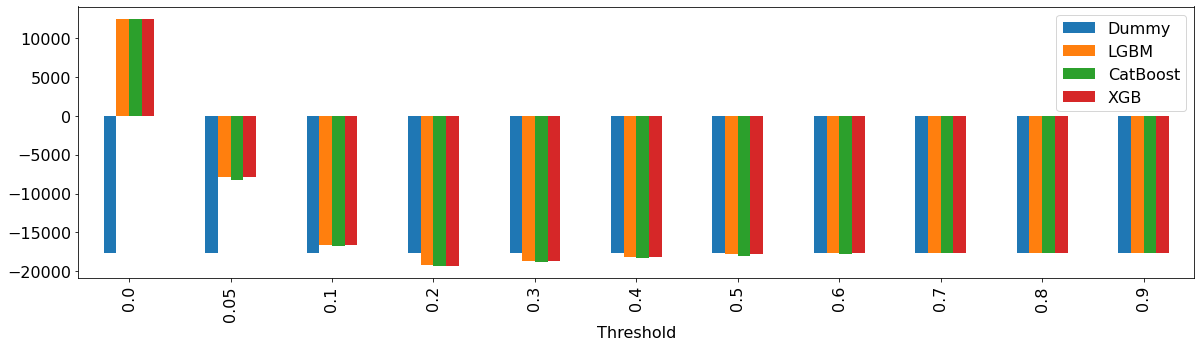

In [26]:
f, (ax1) = plt.subplots(1,1, figsize=(20,5))
qs=cost_res.plot.bar(rot=90,ax=ax1)

In [27]:
if path.exists(file3):
  print('already found')
  df_pred=pd.read_csv(file3)
  listOfStr= df_pred.columns
  for i in listOfStr:
     if 'Unnamed' in i:
         df_pred= df_pred.drop(i, axis=1)
  
  df_eval=pd.read_csv(file4)
  df_eval=df_eval.set_index('Model')
  df_Cmatrix=pd.read_csv(file5)
  listOfStr= df_Cmatrix.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        df_Cmatrix=df_Cmatrix.drop(i, axis=1)
else:
  [df_pred,df_eval, df_Cmatrix]=modeliser_data(nsplits,X_train, Y_train,X_test,Y_test,Classifiers_best,cost_res,'unbalanced')
  df_pred.to_csv(file3)
  df_eval.to_csv(file4)
  df_Cmatrix.to_csv(file5)

already found


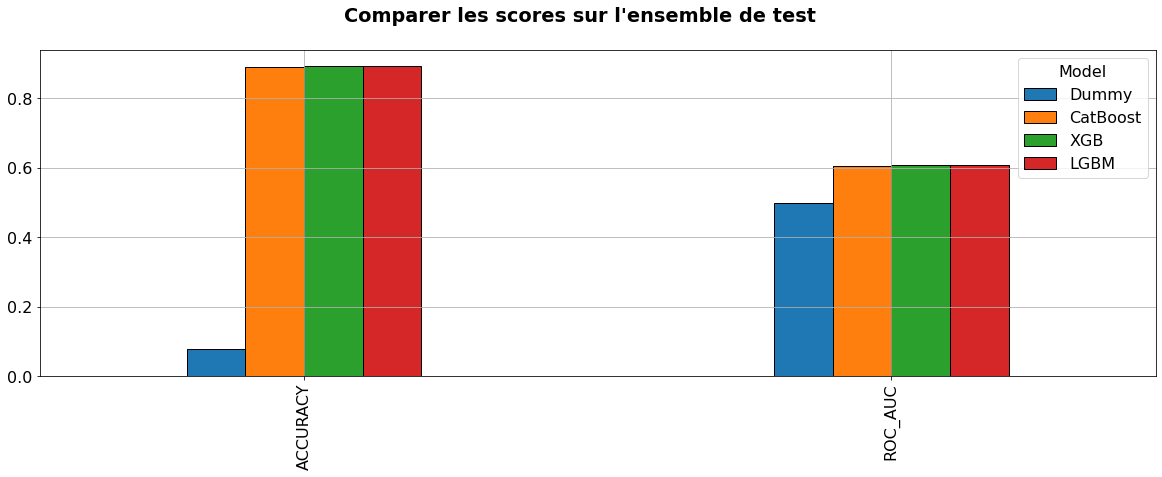

In [28]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sort='ROC_AUC'
titre="Comparer les scores sur l'ensemble de test"
plot_eval(df_eval.T,sort,titre)

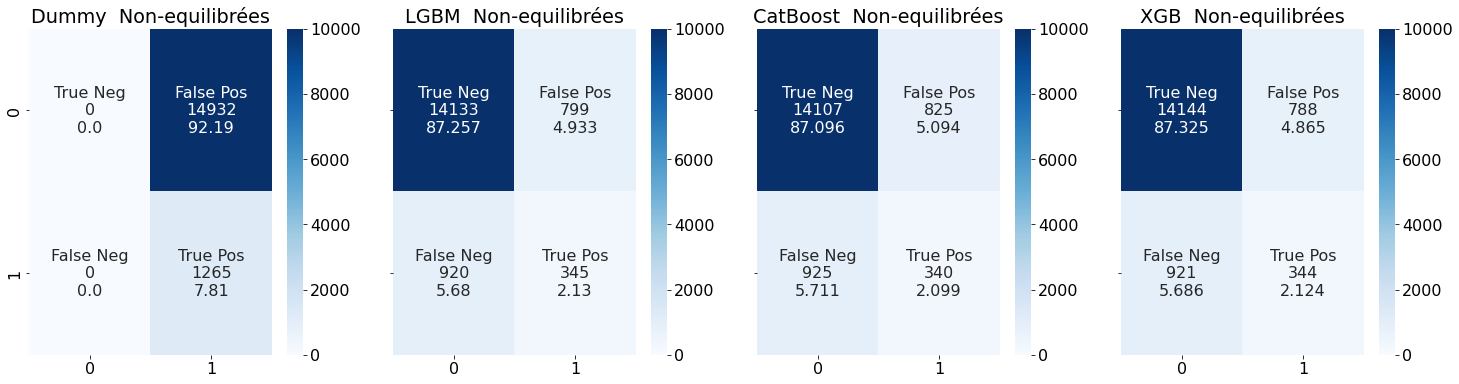

In [29]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(25,6),sharey=True)
ax=[ax1,ax2,ax3,ax4]
tnx=plot_confusion_matrix(Classifiers_best,df_Cmatrix,ax, '  Non-equilibrées', 'conf_matr_n_equi.png')

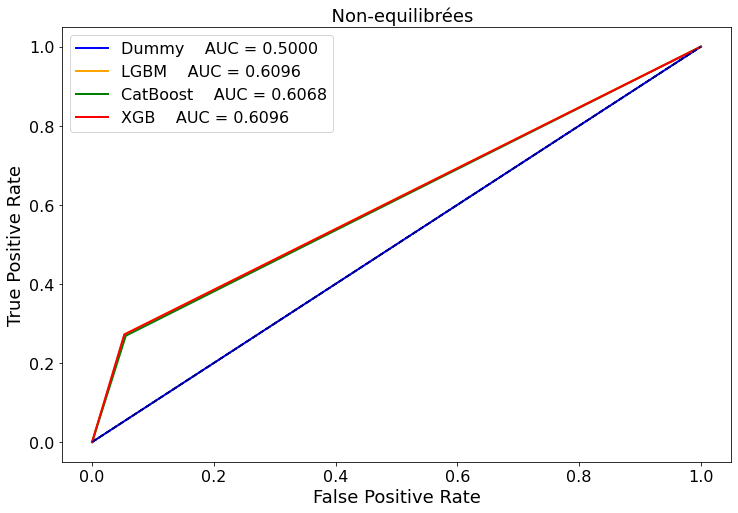

In [30]:
f, (ax1) = plt.subplots(1,1, figsize=(12,8))
ax=[ax1]

tnx=plot_roc_curve(Classifiers_best,df_pred,ax, '  Non-equilibrées','AUC_n_equi.png')

### Modèlisation avec un jeu de données équilibré - en utilisant la technique du  l'undersampling

In [31]:
import imblearn
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1)
X_train_under, Y_train_under = undersample.fit_resample(X_train, Y_train)



In [32]:
file_in=str(dir_data) + '/train_under.csv'
file_in_y=str(dir_data) + '/Y_train_under.csv'
if path.exists(file_in_y):
  print("déjà enregistré")
else:
  X_train_under.to_csv(file_in)
  Y_train_under.to_csv(file_in_y)

déjà enregistré


In [33]:
if path.exists(file1_under):
  print('Best params already found')
  best_params_under =pd.read_csv(file1_under)

  listOfStr= best_params_under.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        best_params_under=best_params_under.drop(i, axis=1)

else:
  best_params_under=find_best_params(nsplits,X_train_under, Y_train_under,Classifiers,params_Classifiers)
  best_params_under.to_csv(file1_under)

Best params already found


In [34]:
best_params_under['XGB'][0]


"{'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}"

In [35]:
Classifiers_best_under = { 
    "Dummy"       : DummyClassifier(strategy="most_frequent"),
    "LGBM"        : LGBMClassifier(max_depth=3,learning_rate= 0.1,n_estimators= 500 ,eval_metric='mlogloss', 
                                                 device='gpu',verbose=-1), 
    "CatBoost"    : CatBoostClassifier(max_depth=3,learning_rate= 0.1,n_estimators= 750 , 
                                                 task_type='GPU',verbose=False),
    "XGB"         : XGBClassifier(max_depth=3,learning_rate= 0.1,n_estimators= 500 ,eval_metric='mlogloss', 
                                             tree_method= 'gpu_hist',verbose=-1 ),
      }

In [36]:
if path.exists(file2_under):
  print('already found')
  cost_res_under=pd.read_csv(file2_under)
  cost_res_under=cost_res_under.set_index('Threshold')
else:
  cost_res_under=find_besoin_metier(nsplits, X_train_under,Y_train_under, X_val, Y_val, Classifiers_best_under)
  cost_res_under.to_csv(file2_under)

already found


In [37]:
if path.exists(file3_under):
  print('already found')
  df_pred_under=pd.read_csv(file3_under)
  listOfStr= df_pred_under.columns
  for i in listOfStr:
     if 'Unnamed' in i:
         df_pred_under= df_pred_under.drop(i, axis=1)
  
  df_eval_under=pd.read_csv(file4_under)
  df_eval_under=df_eval_under.set_index('Model')
  df_Cmatrix_under=pd.read_csv(file5_under)
  listOfStr= df_Cmatrix_under.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        df_Cmatrix_under=df_Cmatrix_under.drop(i, axis=1)
else:
  [df_pred_under,df_eval_under, df_Cmatrix_under]=modeliser_data(nsplits,X_train_under, Y_train_under,X_test,Y_test,
                                                                              Classifiers_best_under,cost_res_under,'under')
  df_pred_under.to_csv(file3_under)
  df_eval_under.to_csv(file4_under)
  df_Cmatrix_under.to_csv(file5_under)

already found


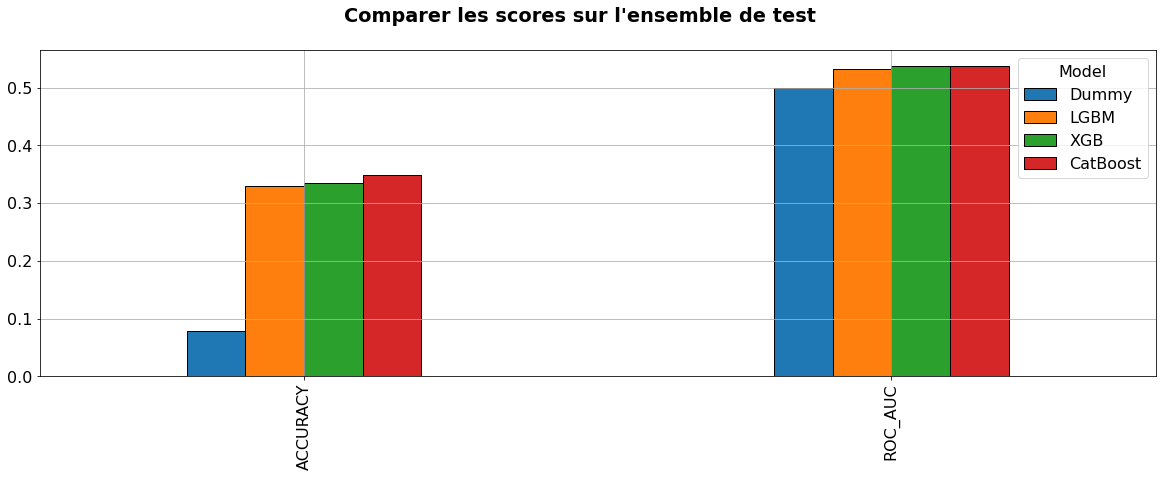

In [38]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sort='ROC_AUC'
titre="Comparer les scores sur l'ensemble de test"
plot_eval(df_eval_under.T,sort,titre)

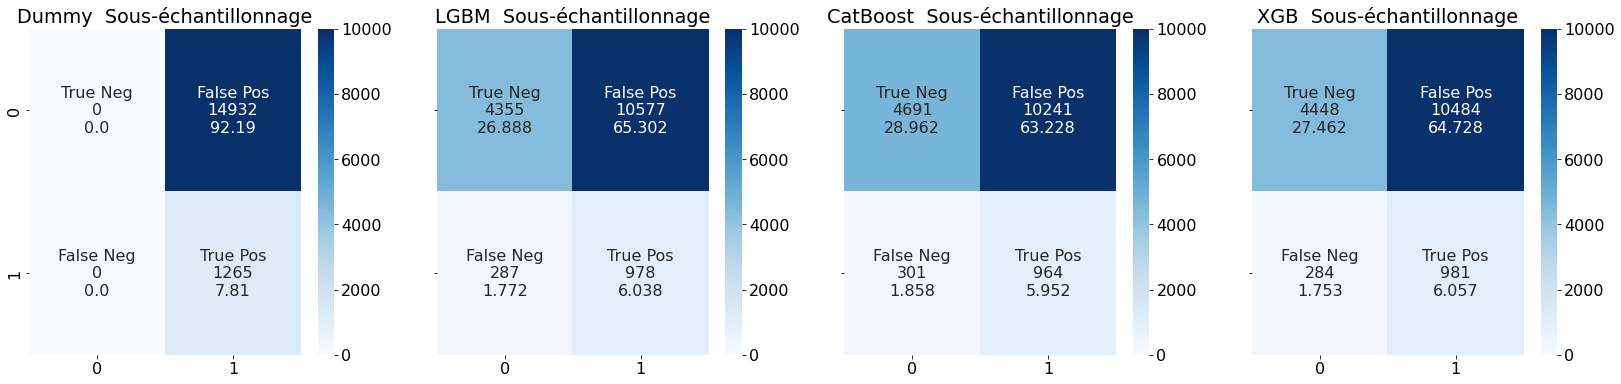

In [39]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(28,6),sharey=True)
ax=[ax1,ax2,ax3,ax4]
tnx=plot_confusion_matrix(Classifiers_best_under,df_Cmatrix_under,ax, '  Sous-échantillonnage', 'conf_matr_sous.png')

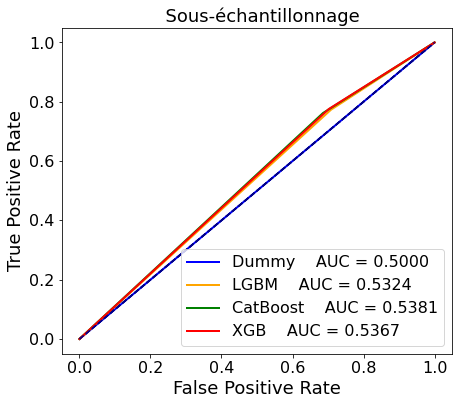

In [40]:
f, (ax1) = plt.subplots(1,1, figsize=(7,6))
ax=[ax1]

tnx=plot_roc_curve(Classifiers_best_under,df_pred_under,ax, '  Sous-échantillonnage','AUC_sous.png')

#### Recherche des meilleurs paramètres pour les modèles

### Modèlisation avec un jeu de données équilibré - en utilisant la technique du suréchantillonnage

In [41]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=seed)
X_train_over, Y_train_over = sm.fit_resample(X_train, Y_train)


In [42]:
file_in=str(dir_data) + '/train_over.csv'
file_in_y=str(dir_data) + '/Y_train_over.csv'
if path.exists(file_in_y):
  print("déjà enregistré")
else:
  X_train_over.to_csv(file_in)
  Y_train_over.to_csv(file_in_y)

déjà enregistré


In [43]:
if path.exists(file1_over):
  print('Best params already found')
  best_params_over =pd.read_csv(file1_over)

  listOfStr= best_params_over.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        best_params_over=best_params_over.drop(i, axis=1)

else:
  best_params_over=find_best_params(nsplits,X_train_over, Y_train_over,Classifiers,params_Classifiers)
  best_params_over.to_csv(file1_over)


Best params already found


In [44]:
best_params_over["XGB"][0]


"{'eval_metric': 'mlogloss', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 2500}"

In [45]:
Classifiers_best_over = { 
    "Dummy"       : DummyClassifier(strategy="most_frequent"),
    "LGBM"        : LGBMClassifier(max_depth=5,learning_rate= 0.01,n_estimators= 2500 , 
                                                  device='gpu',verbose=-1), 
    "CatBoost"    : CatBoostClassifier(max_depth=4,learning_rate= 0.1,n_estimators= 1000 ,
                                                 task_type='GPU',verbose=False),
    "XGB"         : XGBClassifier(max_depth=5,learning_rate= 0.01,n_estimators= 2500 ,eval_metric='mlogloss', 
                                             tree_method= 'gpu_hist' ,verbose=-1),
      }
  

#### Métrique métier 

In [46]:
if path.exists(file2_over):
  print('already found')
  cost_res_over=pd.read_csv(file2_over)
  cost_res_over=cost_res_over.set_index('Threshold')
else:
  cost_res_over=find_besoin_metier(nsplits, X_train_over,Y_train_over, X_val, Y_val, Classifiers_best_over)
  cost_res_over.to_csv(file2_over)


already found


#### Modelisation avec les meilleur parametres

In [47]:
if path.exists(file3_over):
  print('already found')
  df_pred_over=pd.read_csv(file3_over)
  listOfStr= df_pred_over.columns
  for i in listOfStr:
     if 'Unnamed' in i:
         df_pred_over= df_pred_over.drop(i, axis=1)
  
  df_eval_over=pd.read_csv(file4_over)
  df_eval_over=df_eval_over.set_index('Model')
  df_Cmatrix_over=pd.read_csv(file5_over)
  listOfStr     = df_Cmatrix_over.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        df_Cmatrix_over=df_Cmatrix_over.drop(i, axis=1)
else:
  [df_pred_over,df_eval_over, df_Cmatrix_over]=modeliser_data(nsplits,X_train_over, Y_train_over,X_test,Y_test,
                                                                          Classifiers_best_over,cost_res_over,'over')
  df_pred_over.to_csv(file3_over)
  df_eval_over.to_csv(file4_over)
  df_Cmatrix_over.to_csv(file5_over)

already found


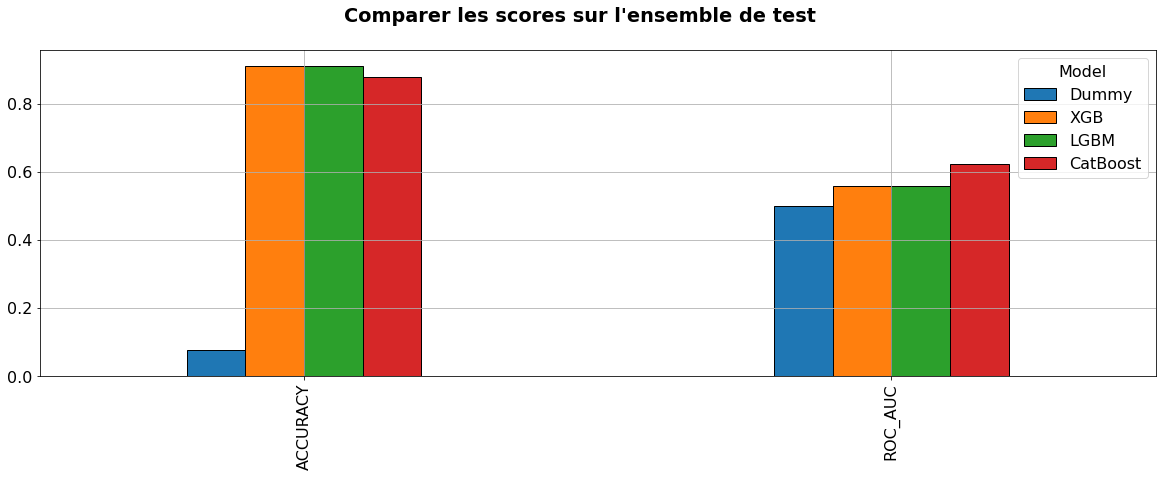

In [48]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sort='ROC_AUC'
titre="Comparer les scores sur l'ensemble de test"
plot_eval(df_eval_over.T,sort,titre)

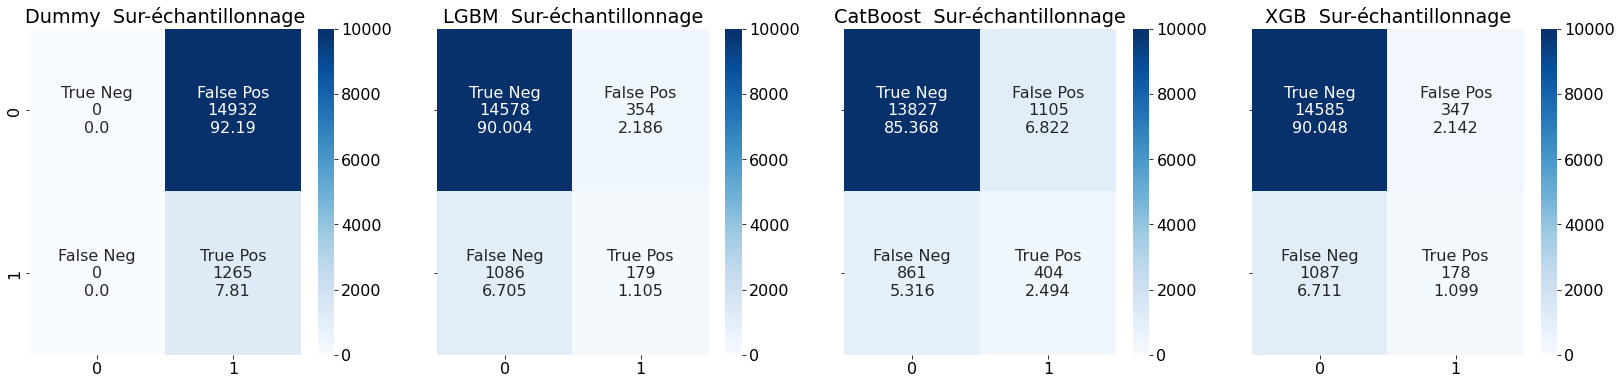

In [49]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(28,6),sharey=True)
ax=[ax1,ax2,ax3,ax4]
tnx=plot_confusion_matrix(Classifiers_best_over,df_Cmatrix_over,ax,'  Sur-échantillonnage', 'conf_matr_sur.png')

In [50]:
file_in=str(dir_data) + '/train_over.csv'
if path.exists(file_in):
  print("déjà enregistré")
else:
  X_train_over.to_csv(file_in)

déjà enregistré


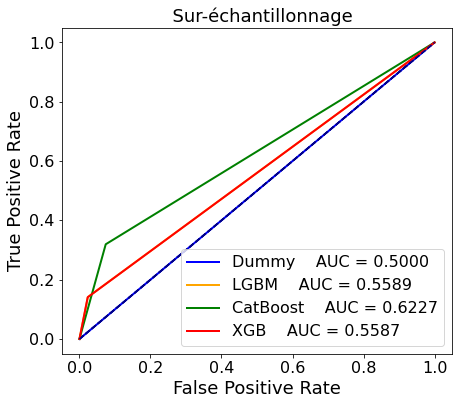

In [51]:
f, (ax1) = plt.subplots(1,1, figsize=(7,6))
ax=[ax1]

tnx=plot_roc_curve(Classifiers_best_over,df_pred_over,ax,'  Sur-échantillonnage','AUC_sur.png')

### Best model
fn must be the lowest

In [52]:
dss=2
minval=min(df_Cmatrix_over["LGBM"][dss],df_Cmatrix_over["XGB"][dss],df_Cmatrix_over["CatBoost"][dss])

for model_idx in Classifiers_best: 
    if df_Cmatrix_over[model_idx][dss]== minval:
      print('Le meilleur modèle est ', model_idx, "avec méthode de sur-échantillonnage")

Le meilleur modèle est  CatBoost avec méthode de sur-échantillonnage


## Analyses
Here we use CatBoostClassifier model with unbalanced data 

#### Check Feature Importance

##### Global

In [64]:
sampling=5000
seed=1
file_in = str(dir_data) + '/persodata_client_test.csv'
df=pd.read_csv(file_in)
perso_list=['CODE_GENDER','NAME_FAMILY_STATUS','OCCUPATION_TYPE','NAME_INCOME_TYPE','ORGANIZATION_TYPE']

df=df.drop(perso_list, axis=1)

X_sample=copy.deepcopy(df)
id_client=copy.deepcopy(df)
X_sample=X_sample.sample(n=sampling, random_state=seed)

id_client=id_client.drop(id_client.columns.difference(['SK_ID_CURR']), axis=1)
X_sample=X_sample.drop('SK_ID_CURR', axis=1)

for model_idx in Classifiers_best: 
    if model_idx =="CatBoost":
       model=Classifiers_best[model_idx]
       model.fit(X_train_over,Y_train_over)
       explainer     = shap.TreeExplainer(model)
       shap_values   = explainer.shap_values(X_sample)  
       expected_value =explainer.expected_value        
 

In [54]:
file_in=str(dir_data) + '/explainer.sav'
pickle.dump(explainer, open(file_in, "wb"))  


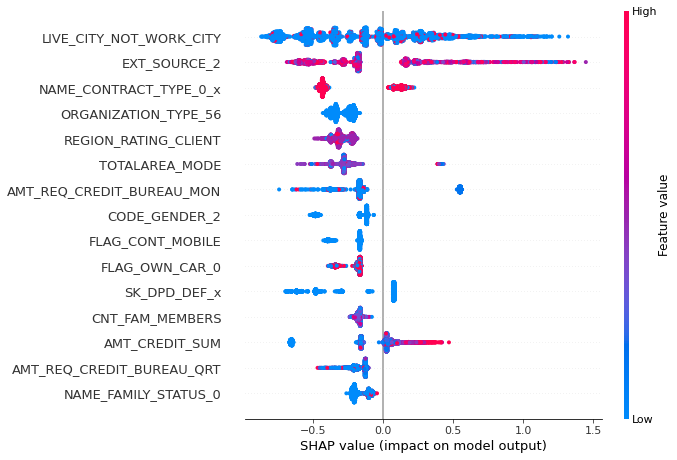

<Figure size 432x288 with 0 Axes>

In [65]:
savename='Global_shap.png'
shap.summary_plot(shap_values, X_sample, max_display=15)
plt.savefig(f"{dir_fig}/{savename}")

Comme le montre la figure ci-dessus, ext_source_2 et ext_source_3 sont les caractéristiques les plus influentes dans décisions d’octroi de crédit. Ces caractéristiques ont tendance à pousser la prédiction vers la mobilité descendante, réduisant de cette façon les chances d'un refus de prêt. Au contraire, le code_gender_0 poussent la prédiction vers la mobilité ascendante, augmentant la chance d’un refus de prêt. 

#### Individual SHAP Value Plot — Local Interpretability

In [66]:

selected_client=137393
individue=id_client[id_client['SK_ID_CURR']==selected_client].index[0] 

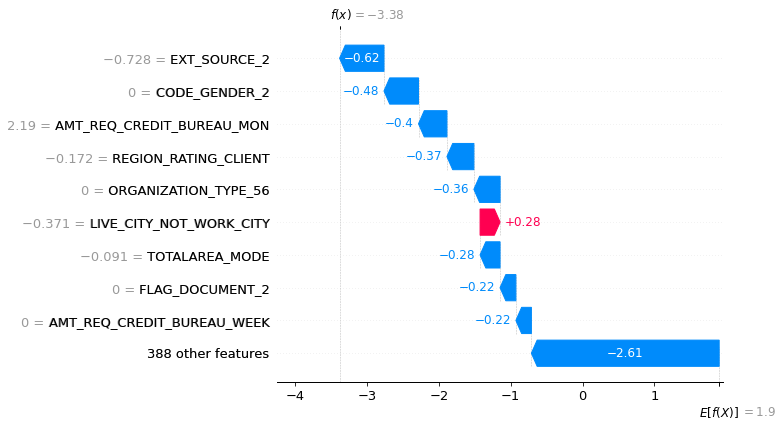

<Figure size 432x288 with 0 Axes>

In [67]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names): #, max_display):
        self.base_values = base_values     # Single value
        self.data = data                   # Raw feature values for 1 row of data
        self.values = values               # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        

shap_object = ShapObject(base_values = explainer.expected_value,
                         values = shap_values[individue,:],  
                         feature_names = X_sample.columns,
                         data = X_sample.iloc[individue,:])

shap.waterfall_plot(shap_object)
savename='local_waterfall_shap.png'
plt.savefig(f"{dir_fig}/{savename}")

In [74]:

shap_values_df= pd.DataFrame(shap_values,columns=X_sample.columns)

max_display=9
why= "Contribution à la décision"
[fig2,base_values]= my_waterfall(shap_values_df,explainer.expected_value, individue, max_display,why)

Seulement LIVE_CITY_NOT_WORK_CITY contribue negativement pour l'octroi de credit


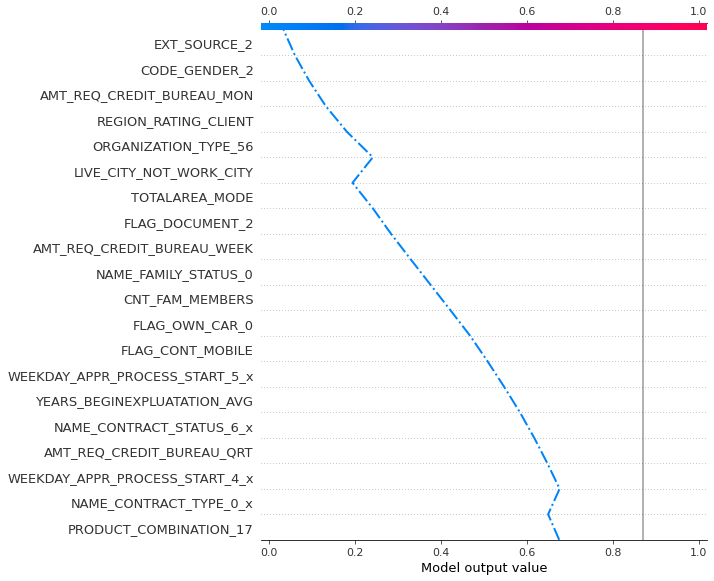

<Figure size 432x288 with 0 Axes>

In [69]:
shap.decision_plot(explainer.expected_value,
                   shap_values[individue,:],
                   feature_names=X_sample.columns.tolist()
                   , highlight=0,link='logit') #    "logit" link transforms log-odds into probabilities


savename='decision_plot_shap.png'
plt.savefig(f"{dir_fig}/{savename}")

Find similar customers

In [70]:
max_display=20
why2="Contribution à la prédiction"
[fig3, cumsum]= my_decision_plot(shap_values_df,explainer.expected_value,individue, max_display, why2,base_values)
